# Graphic Statics IV: Thruss

reference: 
https://block.arch.ethz.ch/brg/files/2012-jiass-vanmele-lachauer-rippmann-block_1380094579.pdf

In [1]:
import math as m

import compas
import compas_ags

from compas_ags.diagrams import FormGraph
from compas_ags.diagrams import FormDiagram
from compas_ags.diagrams import ForceDiagram
from compas_ags.ags import graphstatics
from compas_ags.viewers import Viewer

import warnings
warnings.filterwarnings("ignore")

###    create a truss

In [2]:
### 
###  INPUT HOW MANY LOADS TO ADD
###  INPUT SPAN LENGTH
###
loads = 5
span = 10

In [3]:
def catenary_curve(x, type='hanging_cable', a=5, xm=0, ym=0):
    if type is 'arch':
        return ym - a * m.cosh((x - xm) / a)
    elif type is 'hanging_cable':
        return ym + a * m.cosh((x - xm) / a)

In [4]:
nodes = []
edges = []

# to save the pair of top and bottom chords
chord_pairs = []

# truss
y0 = catenary_curve(- span / 2)
for i in range(loads + 2):
    x = i * span / (loads + 1) - span / 2 
    nodes.append([x, y0, 0])
    if i == 0: 
        edges.append(tuple([i, i+1]))
        edges.append(tuple([i, i+2])) 
        chord_pairs.append([tuple([i, i+1]), tuple([i, i+2])])
    elif i == loads:
        nodes.append([x, catenary_curve(x), 0])
        edges.append(tuple([i * 2 -1, i * 2 + 1]))
        edges.append(tuple([i * 2 - 1, i * 2]))
        edges.append(tuple([i * 2, i * 2 + 1]))
        chord_pairs.append([tuple([i * 2 -1, i * 2 + 1]), tuple([i * 2, i * 2 + 1])])
    elif i != loads + 1:
        nodes.append([x, catenary_curve(x), 0])
        edges.append(tuple([i * 2 - 1, i * 2 + 1]))
        edges.append(tuple([i * 2 - 1, i * 2]))
        edges.append(tuple([i * 2, i * 2 + 2]))
        chord_pairs.append([tuple([i * 2 -1, i * 2 + 1]), tuple([i * 2, i * 2 + 2])])
        
# vertical reaction force
for i in range(loads + 2):
    x = i * span / (loads + 1) - span / 2 
    if i == 0:
        nodes.append([x, y0 - 1, 0])
        edges.append(tuple([0, len(nodes) - 1]))
    elif i == loads + 1:
        nodes.append([x, y0 - 1, 0])
        edges.append(tuple([i * 2 - 1, len(nodes) - 1]))
    else:
        nodes.append([x, y0 + 1, 0])
        edges.append(tuple([i * 2 - 1, len(nodes) - 1]))
    
# horizontal reaction force
nodes.append([-span / 2 - 1.0, y0, 0])
edges.append(tuple([0, len(nodes) - 1]))
nodes.append([span / 2 + 1.0, y0, 0])
edges.append(tuple([2 * loads + 1, len(nodes) - 1]))

In [5]:
# make form and force diagrams
graph = FormGraph.from_nodes_and_edges(nodes, edges)
form = FormDiagram.from_graph(graph)
force = ForceDiagram.from_formdiagram(form)

###    prescribe edge force density and set fixed vertices

In [6]:
# set the magnitude of the applied load
e =  {'v': list(form.vertices_where({'x': - span / 2, 'y': y0}))[0],
       'u': list(form.vertices_where({'x': - span / 2 , 'y': y0-1.0}))[0]}
form.edge_attribute((e['u'], e['v']), 'is_ind', True)
form.edge_attribute((e['u'], e['v']), 'q', -5.)

e =  {'v': list(form.vertices_where({'x': - span / 2, 'y': y0}))[0],
       'u': list(form.vertices_where({'x': - span / 2 -1 , 'y':y0}))[0]}
form.edge_attribute((e['u'], e['v']), 'is_ind', True)
form.edge_attribute((e['u'], e['v']), 'q', 0.)

# set the fixed points
left = list(form.vertices_where({'x': - span / 2, 'y': y0}))[0]
right = list(form.vertices_where({'x': span / 2, 'y': y0}))[0]
fixed = [left, right]
form.set_fixed(fixed)
force.set_anchor([0])

# update the diagrams
graphstatics.form_update_q_from_qind(form)
graphstatics.force_update_from_form(force, form)

### display force and form diagrams

In [7]:
# store lines representing the current state of equilibrium
form_lines = []
for u, v in form.edges():
    form_lines.append({
        'start': form.vertex_coordinates(u, 'xy'),
        'end'  : form.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

force_lines = []
for u, v in force.edges():
    force_lines.append({
        'start': force.vertex_coordinates(u, 'xy'),
        'end'  : force.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

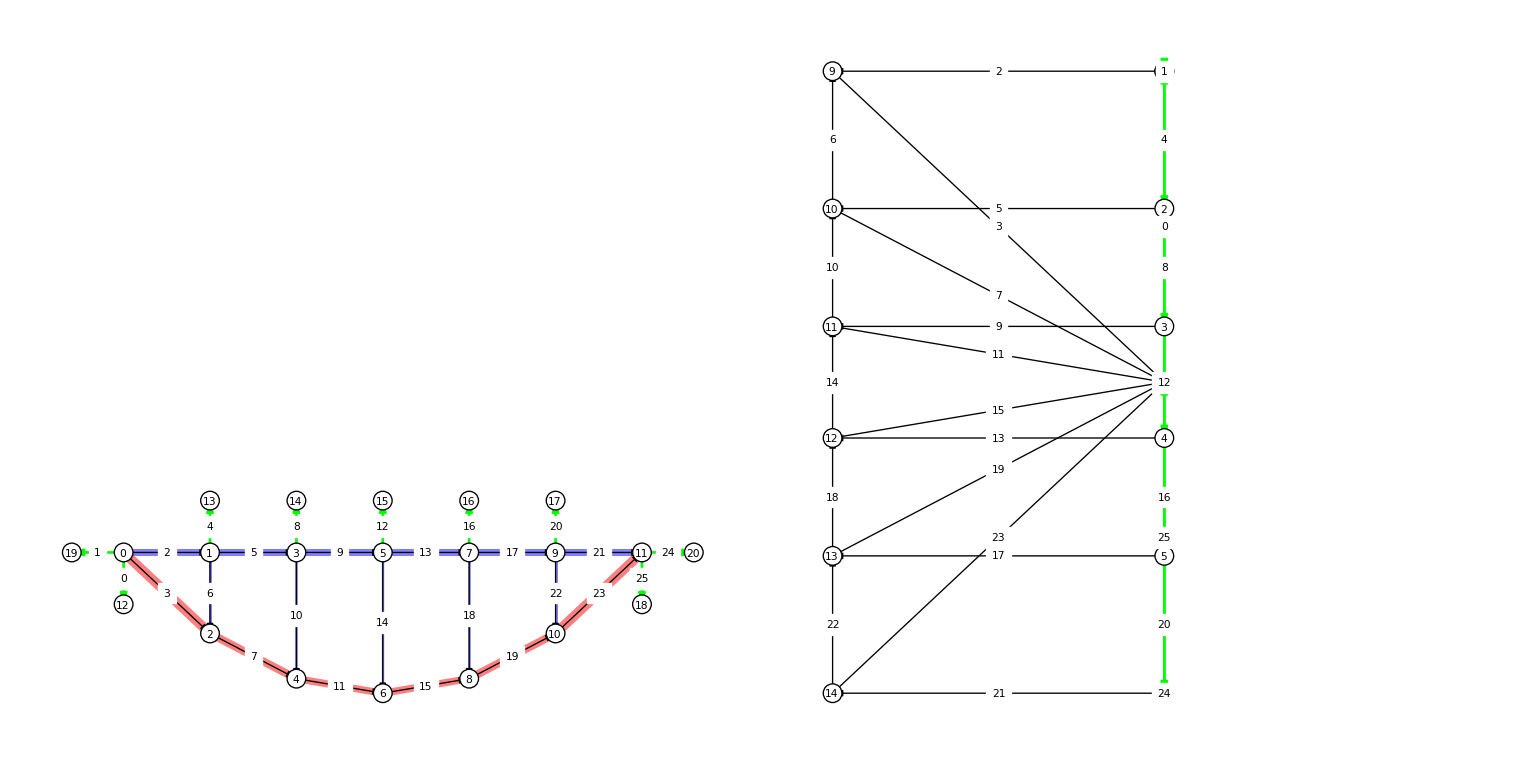

In [8]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(
    arrows_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in form.vertices()},
    edgelabel={uv: index for index, uv in enumerate(form.edges())},)

    
viewer.draw_force(
    arrows_on=True,
    vertexsize=0.15,
    vertexlabel={key: key for key in force.vertices()},
    edgelabel=viewer.check_edge_pairs()[1])

viewer.show()

### modify force in the bottom chord to be constant

In [9]:
from compas_ags.ags2.constraints import ConstraintsCollection, HorizontalFix, VerticalFix
import compas_ags.ags2.rootfinding as rf
import numpy as np

# set constraints
# find vertices in the force diagram and move them to the right
# which means making the internal forces and boundary forces smaller
C = ConstraintsCollection(form)
C.add_constraint(HorizontalFix(form, left))
C.add_constraint(VerticalFix(form, left))
C.add_constraint(HorizontalFix(form, right))
for i in range(loads):
    C.add_constraint(HorizontalFix(form, i * 2 + 1))
C.constrain_dependent_leaf_edges_lengths()

# modify the geometry of the force diagram and update the form diagram using Newton's method
xy = np.array(form.xy(), dtype=np.float64).reshape((-1, 2))
_xy = np.array(force.xy(), dtype=np.float64).reshape((-1, 2))

In [10]:
from compas.geometry import distance_point_point
from itertools import chain

form_edges = list(form.edges())
top_indices = [form_edges.index(pairs[0]) for pairs in chord_pairs]
bottom_indices = [form_edges.index(pairs[1]) for pairs in chord_pairs]
force_idx_uv = {idx:uv for uv, idx in viewer.check_edge_pairs()[1].items()}

force_bottom = [force_idx_uv[bottom] for bottom in bottom_indices]
force_top = [force_idx_uv[top] for top in top_indices]
common_idices = [list(set(bottom).intersection(top)) for (bottom, top) in zip(force_bottom, force_top)]

# find the center of the circle
cen_idx = max(set(chain.from_iterable(force_bottom)), key=force_bottom.count) 

# if the target force / radius is not given
if True:
    radius = 0
    for (u, v) in force_bottom:
        xy_u = force.vertex_coordinates(u)
        xy_v = force.vertex_coordinates(v)
        dis = distance_point_point(xy_u, xy_v)
        if dis > radius: radius = dis 

for i, (bottom, top, common_idx) in enumerate(zip(force_bottom, force_top, common_idices)):
    cathetus_a = distance_point_point(force.vertex_coordinates(top[0]), force.vertex_coordinates(top[1]))
    catetus_b_pt = list(set(top) - set(common_idx))[0]
    cathetus_b = distance_point_point(force.vertex_coordinates(cen_idx), force.vertex_coordinates(catetus_b_pt))
    x_dis = m.sqrt(radius ** 2 - cathetus_b ** 2) - cathetus_a
    _xy[force.key_index()[common_idx[0]], 0] -= x_dis
    
    print(i, bottom, top, common_idx)

0 (8, 9) (1, 9) [9]
1 (8, 10) (2, 10) [10]
2 (8, 11) (3, 11) [11]
3 (8, 12) (4, 12) [12]
4 (8, 13) (5, 13) [13]
5 (8, 14) (6, 14) [14]


In [11]:
# compute the form diagram
_X_goal = np.vstack((np.asmatrix(_xy[:, 0]).transpose(), np.asmatrix(_xy[:, 1]).transpose()))
rf.compute_form_from_force_newton(form, force, _X_goal, constraints=C)

i: 1 diff: 3.38e+00
i: 2 diff: 3.36e+00
i: 3 diff: 5.22e-01
i: 4 diff: 1.69e-02
i: 5 diff: 1.95e-05
i: 6 diff: 2.95e-11
i: 7 diff: 2.36e-14
Converged in 8 iterations


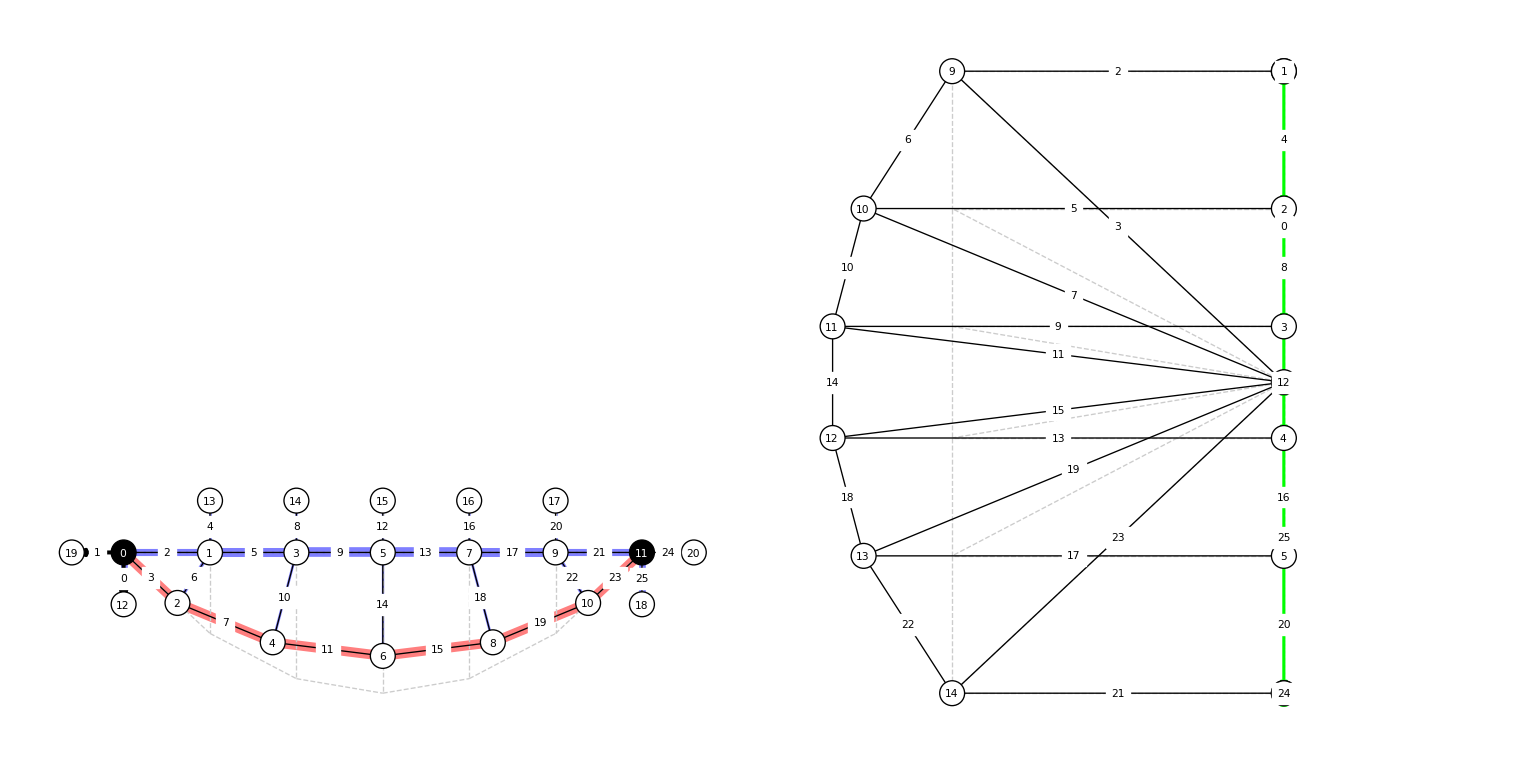

In [12]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(lines=form_lines,
                 forces_on=True,
                 vertexlabel={key: key for key in form.vertices()},
                 external_on=False,
                 vertexsize=0.2,
                 vertexcolor={key: '#000000' for key in fixed},
                 edgelabel={uv: index for index, uv in enumerate(form.edges())}
)

viewer.draw_force(lines=force_lines,
                  vertexlabel={key: key for key in force.vertices()},
                  vertexsize=0.2,
                  edgelabel=viewer.check_edge_pairs()[1]
)

viewer.show()

In [13]:
# store lines representing the current state of equilibrium
form_lines = []
for u, v in form.edges():
    form_lines.append({
        'start': form.vertex_coordinates(u, 'xy'),
        'end'  : form.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

force_lines = []
for u, v in force.edges():
    force_lines.append({
        'start': force.vertex_coordinates(u, 'xy'),
        'end'  : force.vertex_coordinates(v, 'xy'),
        'width': 1.0,
        'color': '#cccccc',
        'style': '--'
    })

In [14]:
def angle_vectors_xy_sign(v1, v2):
    # compute the angle between the XY components of two vectors clockwise
    x1 = v1[0]
    y1 = v1[1]
    x2 = v2[0]
    y2 = v2[1]
    dot = x1*x2 + y1*y2 
    det = x1*y2 - y1*x2  
    ang = m.atan2(det, dot) 
    return ang

In [15]:
from compas.geometry import rotate_points_xy

### 
###  INPUT SCALE FACTOR
###
sca = 1.1  # 0 to 1

cen_xy = force.vertex_coordinates(cen_idx)
for i, (bottom, top, common_idx) in enumerate(zip(force_bottom, force_top, common_idices)):
    common_xy = force.vertex_coordinates(common_idx[0])
    vec_bottom = [a - b for a, b in zip(common_xy, cen_xy)]
    ori_ang = angle_vectors_xy_sign(vec_bottom, [-1, 0, 0])
    ang = ori_ang * (1 - sca)
    new_xy = rotate_points_xy([common_xy], ang, origin=cen_xy)[0]
    
    _xy[force.key_index()[common_idx[0]], 0] += new_xy[0] - common_xy[0]
    _xy[force.key_index()[common_idx[0]], 1] += new_xy[1] - common_xy[1]

In [16]:
# compute the form diagram
_X_goal = np.vstack((np.asmatrix(_xy[:, 0]).transpose(), np.asmatrix(_xy[:, 1]).transpose()))
rf.compute_form_from_force_newton(form, force, _X_goal, constraints=C)

i: 1 diff: 8.87e-01
i: 2 diff: 5.94e-02
i: 3 diff: 3.03e-04
i: 4 diff: 6.79e-09
i: 5 diff: 2.69e-14
Converged in 6 iterations


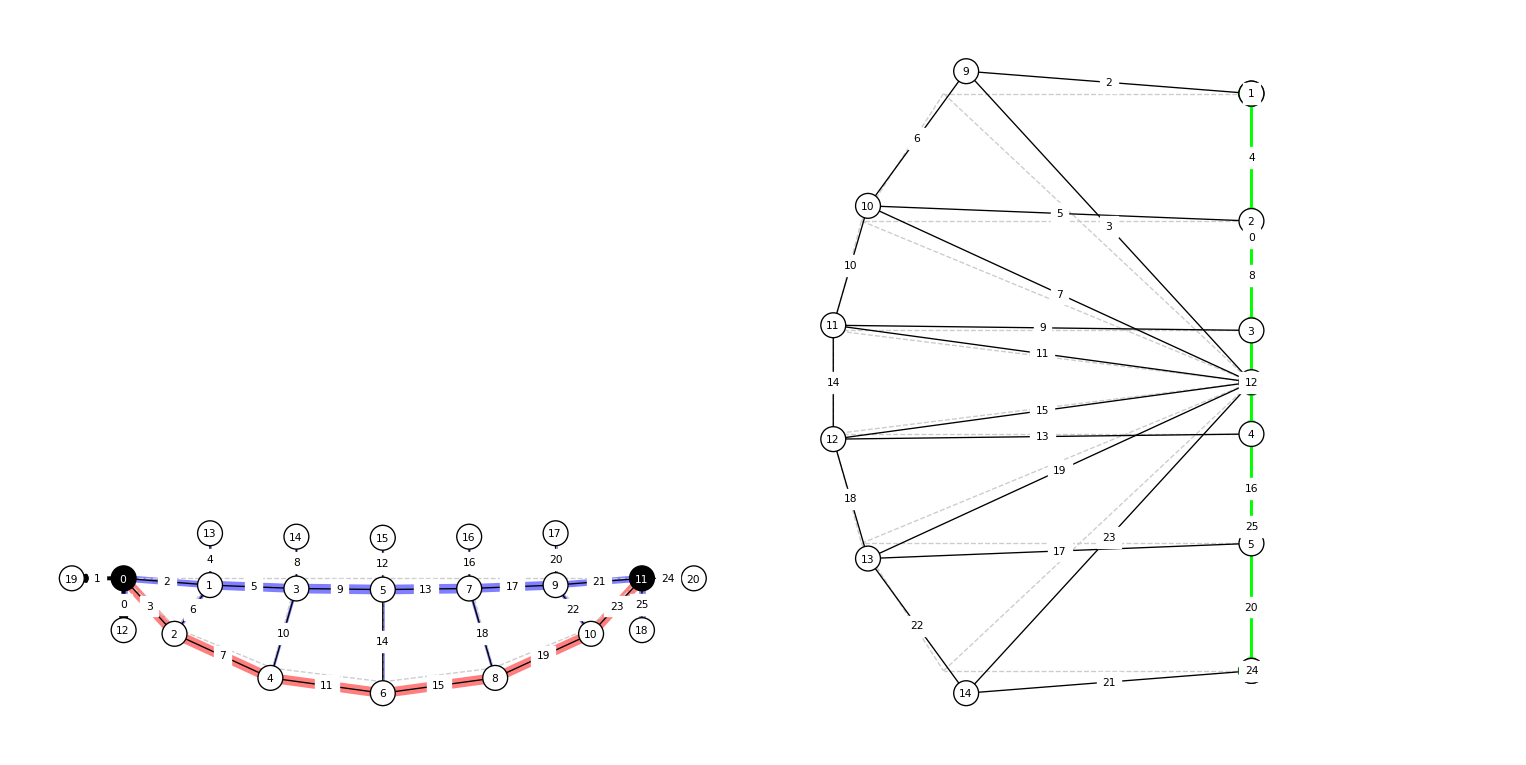

In [17]:
viewer = Viewer(form, force, delay_setup=False)

viewer.draw_form(lines=form_lines,
                 forces_on=True,
                 vertexlabel={key: key for key in form.vertices()},
                 external_on=False,
                 vertexsize=0.2,
                 vertexcolor={key: '#000000' for key in fixed},
                 edgelabel={uv: index for index, uv in enumerate(form.edges())}
)

viewer.draw_force(lines=force_lines,
                  vertexlabel={key: key for key in force.vertices()},
                  vertexsize=0.2,
                  edgelabel=viewer.check_edge_pairs()[1]
)

viewer.show()